In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammeddalkran/masked-facerecognition")

print("Path to dataset files:", path)

100%|██████████| 593M/593M [00:35<00:00, 17.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4


In [2]:
import os

# Path where the dataset is downloaded
dataset_path = "/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4"  # Replace with actual path

# List files and directories inside the dataset
files = os.listdir(dataset_path)

# Print the list of files and directories
for file in files:
    print(file)


AFDB_masked_face_dataset
AFDB_face_dataset


Previewing 3 unmasked images from /root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset:


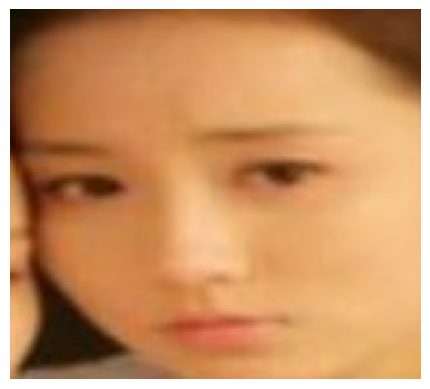

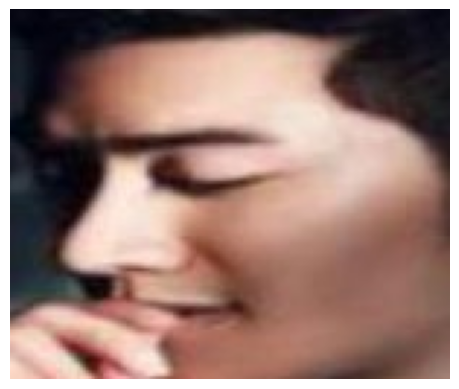

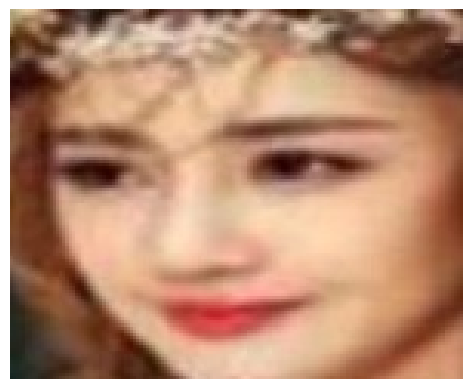

Total number of unmasked images: 90468


In [3]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Define the path to unmasked face dataset
unmasked_path = os.path.join(dataset_path, 'AFDB_face_dataset')

# List all files in the unmasked dataset directory
def get_image_files(folder_path):
    image_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):  # Check for common image extensions
                image_files.append(os.path.join(root, file))
    return image_files

# Get all image files in the unmasked dataset
unmasked_files = get_image_files(unmasked_path)

# Randomly pick a few images to preview
def preview_images(file_list):
    for _ in range(3):  # Preview 3 random images
        random_image = random.choice(file_list)
        img = Image.open(random_image)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Preview images from the unmasked dataset
print(f"Previewing 3 unmasked images from {unmasked_path}:")
preview_images(unmasked_files)

# Print the total number of unmasked images
print(f"Total number of unmasked images: {len(unmasked_files)}")


In [10]:
import random

# Sampling a subset of the images (e.g., 1,000 images)
subset_size = 10000  # Adjust as needed
subset_files = random.sample(unmasked_files, subset_size)
# Verify the selected subset
print(f"Sample of 10,000 unmasked image file paths:")
print(subset_files[:5])  # Display the first 5 file paths



Sample of 10,000 unmasked image file paths:
['/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset/AFDB_face_dataset/tangyixin/1_0_tangyixin_0151.jpg', '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset/AFDB_face_dataset/lizhiting/0_0_lizhiting_0130.jpg', '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset/AFDB_face_dataset/lanyingying/1_0_lanyingying_0177.jpg', '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset/AFDB_face_dataset/yinzheng/1_0_yinzheng_0146.jpg', '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset/AFDB_face_dataset/lixirui/1_0_lixirui_0205.jpg']


In [11]:
import random
from PIL import Image
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader,random_split


# Assuming unmasked_files contains the file paths of your images
subset_size = 10000  # Adjust as needed
subset_files = random.sample(unmasked_files, subset_size)

# Define the transformation pipeline with augmentation
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])


# Custom dataset class to load images
class FaceDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB format

        # Apply transformations (augmentation and normalization)
        if self.transform:
            image = self.transform(image)

        return image

# Create a DataLoader for the subset of images
dataset = FaceDataset(subset_files, transform=transform)

# Define the split sizes
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle the test set

# Print the sizes to confirm
print(f"Train set size: {len(train_dataset)}, Test set size: {len(test_dataset)}")


Train set size: 9000, Test set size: 1000


In [12]:
from torchvision.models import resnet50, ResNet50_Weights

class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained Resnet model."""
        super(resnet_feature_extractor, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False



        # Hook to extract feature maps
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map on self.featured."""
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self, input):

        self.features = []
        with torch.no_grad():
            _ = self.model(input)

        self.avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2]         # Feature map sizes h, w
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        patch = torch.cat(resized_maps, 1)            # Merge the resized feature maps

        return patch

Layer 2 feature map shape: torch.Size([1, 512, 28, 28])
Layer 3 feature map shape: torch.Size([1, 1024, 14, 14])
Concatenated feature map shape: torch.Size([1, 1536, 28, 28])


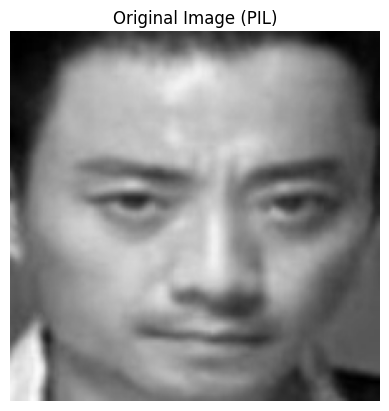

In [13]:
import torch
from torchvision.transforms import ToTensor, Resize, Normalize, Compose, ToPILImage
from PIL import Image
import matplotlib.pyplot as plt

# Define the transformation (ResNet50 default)
transform = Compose([
    Resize((224, 224)),  # ResNet expects 224x224 images
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ResNet normalization
])

# Select a single image from the train dataset
sample = train_dataset[0]  # Get the first sample
image = sample[0]  # Extract the image (adjust based on the actual return structure)

# Convert to PIL Image if the image is a tensor
to_pil = ToPILImage()

# If the image is a tensor, check if it is grayscale (1 channel), and convert to RGB if so
if image.ndimension() == 3 and image.shape[0] == 1:  # Single channel (grayscale)
    image = image.repeat(3, 1, 1)  # Repeat the single channel to make it RGB

# Convert to PIL Image
image_pil = to_pil(image)

# Check if the image is already in RGB format
if image_pil.mode != 'RGB':
    image_pil = image_pil.convert('RGB')  # Ensure it's in RGB format

# Apply the transformation and add a batch dimension
image_tensor = transform(image_pil).unsqueeze(0)  # Add batch dimension

# Initialize the feature extractor
backbone = resnet_feature_extractor()

# Extract features
with torch.no_grad():  # Disable gradient calculations for inference
    feature = backbone(image_tensor)

# Print the shapes of the feature maps from layer2 and layer3
print("Layer 2 feature map shape:", backbone.features[0].shape)
print("Layer 3 feature map shape:", backbone.features[1].shape)

# Print the final concatenated feature map shape
print("Concatenated feature map shape:", feature.shape)

# Visualize the image
plt.imshow(image_pil)
plt.title("Original Image (PIL)")
plt.axis("off")
plt.show()


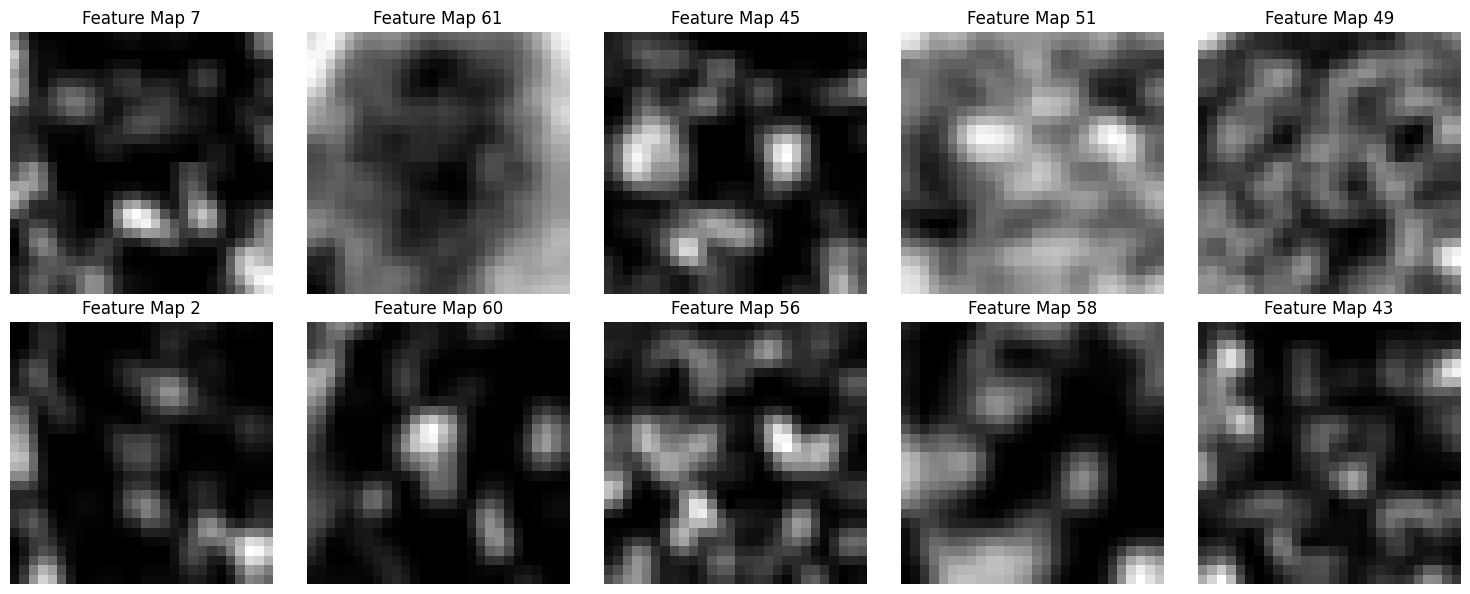

In [14]:
# Select 10 random indices for feature maps
indices = torch.randperm(64)[:10]

# Plot the selected feature maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(feature[0,idx].detach().cpu(), cmap='gray')
    axes[row, col].set_title(f'Feature Map {idx}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [16]:
import torch.nn as nn

class FeatCAE(nn.Module):
    """Autoencoder."""

    def __init__(self, in_channels=1000, latent_dim=50, is_bn=True):
        super(FeatCAE, self).__init__()

        layers = []
        layers += [nn.Conv2d(in_channels, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, latent_dim, kernel_size=1, stride=1, padding=0)]

        self.encoder = nn.Sequential(*layers)

        # if 1x1 conv to reconstruct the rgb values, we try to learn a linear combination
        # of the features for rgb
        layers = []
        layers += [nn.Conv2d(latent_dim, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, in_channels, kernel_size=1, stride=1, padding=0)]
        # layers += [nn.ReLU()]

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
import torch.optim as optim
model = FeatCAE(in_channels=1536, latent_dim=100).cuda()
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

  2%|▏         | 1/50 [01:15<1:01:17, 75.05s/it]

Epoch [1/50], Loss: 0.0803, Validation Loss: 0.0808


 12%|█▏        | 6/50 [07:26<54:33, 74.40s/it]

Epoch [6/50], Loss: 0.0502, Validation Loss: 0.0512


 22%|██▏       | 11/50 [13:38<48:24, 74.46s/it]

Epoch [11/50], Loss: 0.0453, Validation Loss: 0.0458


 32%|███▏      | 16/50 [19:51<42:12, 74.48s/it]

Epoch [16/50], Loss: 0.0492, Validation Loss: 0.0429


 42%|████▏     | 21/50 [26:03<35:58, 74.43s/it]

Epoch [21/50], Loss: 0.0454, Validation Loss: 0.0417


 52%|█████▏    | 26/50 [32:15<29:48, 74.52s/it]

Epoch [26/50], Loss: 0.0477, Validation Loss: 0.0400


 62%|██████▏   | 31/50 [38:29<23:39, 74.70s/it]

Epoch [31/50], Loss: 0.0389, Validation Loss: 0.0392


 72%|███████▏  | 36/50 [44:42<17:25, 74.69s/it]

Epoch [36/50], Loss: 0.0423, Validation Loss: 0.0384


 82%|████████▏ | 41/50 [50:56<11:11, 74.66s/it]

Epoch [41/50], Loss: 0.0605, Validation Loss: 0.0492


 92%|█████████▏| 46/50 [57:09<04:58, 74.61s/it]

Epoch [46/50], Loss: 0.0435, Validation Loss: 0.0373


100%|██████████| 50/50 [1:02:07<00:00, 74.56s/it]


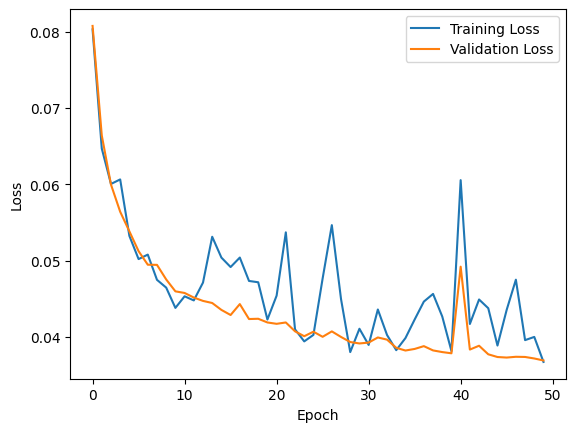

In [20]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device (GPU or CPU)
model = model.to(device)
backbone = backbone.to(device)

# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []

num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train()
    for data in train_dataloader:
        # Move data to the device
        data = data.to(device)

        with torch.no_grad():
            features = backbone(data)

        # Forward pass
        output = model(features)

        # Compute the loss
        loss = criterion(output, features)

        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    Loss.append(loss.item())

    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for data in test_dataloader:
            # Move data to the device
            data = data.to(device)

            features = backbone(data)
            output = model(features)
            val_loss = criterion(output, features)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)

    if epoch % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss_avg:.4f}')

# Plot training and validation loss
plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'autoencoder_with_resnet_deep_features.pth')


In [ ]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device (GPU or CPU)
ckpoints = torch.load('autoencoder_with_resnet_deep_features.pth')
model.load_state_dict(ckpoints)

model.eval()
model = model.to(device)
backbone = backbone.to(device)

# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []

num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train()
    for data in train_dataloader:
        # Move data to the device
        data = data.to(device)

        with torch.no_grad():
            features = backbone(data)

        # Forward pass
        output = model(features)

        # Compute the loss
        loss = criterion(output, features)

        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    Loss.append(loss.item())

    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for data in test_dataloader:
            # Move data to the device
            data = data.to(device)

            features = backbone(data)
            output = model(features)
            val_loss = criterion(output, features)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)

    if epoch % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss_avg:.4f}')

# Plot training and validation loss
plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'autoencoder_with_resnet_deep_featuresv2.pth')


<ipython-input-33-8f03418a1a79>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpoints = torch.load('autoencoder_with_resnet_deep_features.pth')
  2%|▏         | 1/50 [01

Epoch [1/50], Loss: 0.0379, Validation Loss: 0.0367


 12%|█▏        | 6/50 [07:27<54:39, 74.53s/it]

Epoch [6/50], Loss: 0.0425, Validation Loss: 0.0365


 22%|██▏       | 11/50 [13:40<48:29, 74.62s/it]

Epoch [11/50], Loss: 0.0377, Validation Loss: 0.0357


 32%|███▏      | 16/50 [19:54<42:21, 74.74s/it]

Epoch [16/50], Loss: 0.0355, Validation Loss: 0.0356


 42%|████▏     | 21/50 [26:08<36:08, 74.77s/it]

Epoch [21/50], Loss: 0.0397, Validation Loss: 0.0354


 52%|█████▏    | 26/50 [32:21<29:54, 74.78s/it]

Epoch [26/50], Loss: 0.0350, Validation Loss: 0.0352


 60%|██████    | 30/50 [37:20<24:52, 74.64s/it]

In [ ]:
from google.colab import files

# Save the model
torch.save(model.state_dict(), 'autoencoder_with_resnet_deep_featuresv2.pth')

# Download the model file
files.download('autoencoder_with_resnet_deep_featuresv2.pth')


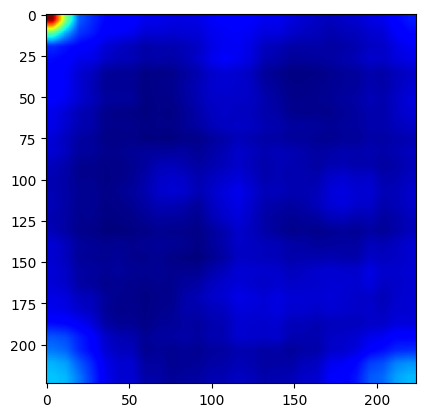

In [28]:
import torch
from torchvision.transforms import ToPILImage, Compose, Resize, ToTensor, Normalize
import matplotlib.pyplot as plt

# Assuming 'train_dataset' is already loaded and the image is a tensor
sample = train_dataset[0]  # Get the first sample
image = sample[0]  # Extract the image

# Convert the image to PIL Image
to_pil = ToPILImage()
image_pil = to_pil(image)

# Check if the image is grayscale (1 channel) and convert to RGB if necessary
if image.ndimension() == 3 and image.shape[0] == 1:  # Single channel (grayscale)
    image = image.repeat(3, 1, 1)  # Repeat the single channel to make it RGB

# Convert to PIL Image again after modification
image_pil = to_pil(image)

# Check if the image is already in RGB format
if image_pil.mode != 'RGB':
    image_pil = image_pil.convert('RGB')  # Ensure it's in RGB format

# Define the transformation
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Typical ImageNet normalization
])

# Apply the transformation and add a batch dimension
image_tensor = transform(image_pil).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

# Pass the image through the backbone (feature extractor)
with torch.no_grad():
    features = backbone(image_tensor)

# Forward pass through the model
recon = model(features)

# Compute the reconstruction error
recon_error = ((features - recon) ** 2).mean(axis=(1)).unsqueeze(0)

# Upscale the error map to match the original input resolution
segm_map = torch.nn.functional.interpolate(
    recon_error,
    size=(224, 224),
    mode='bilinear'
)

# Display the segmentation map
plt.imshow(segm_map.squeeze().detach().cpu().numpy(), cmap='jet')  # Detach before converting to numpy
plt.show()


In [29]:
def decision_function(segm_map):

    mean_top_10_values = []

    for map in segm_map:
        # Flatten the tensor
        flattened_tensor = map.reshape(-1)

        # Sort the flattened tensor along the feature dimension (descending order)
        sorted_tensor, _ = torch.sort(flattened_tensor,descending=True)

        # Take the top 10 values along the feature dimension
        mean_top_10_value = sorted_tensor[:10].mean()

        mean_top_10_values.append(mean_top_10_value)

    return torch.stack(mean_top_10_values)

In [30]:
model.eval()

RECON_ERROR=[]
for data in train_dataloader:

    with torch.no_grad():
        features = backbone(data.cuda()).squeeze()
        # Forward pass
        recon = model(features)
    # Compute the loss
    segm_map =  ((features-recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    anomaly_score = decision_function(segm_map)
    # anomaly_score = segm_map.mean(axis=(1,2))

    RECON_ERROR.append(anomaly_score)

RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

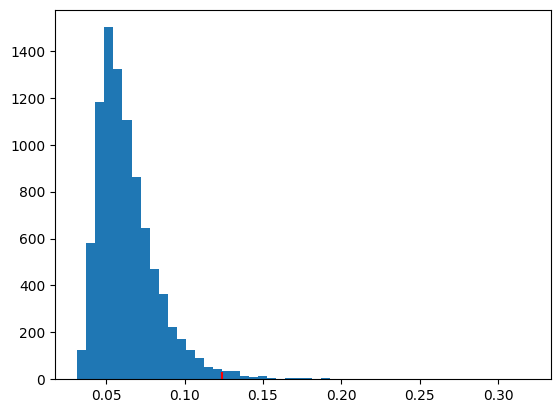

In [32]:
import numpy as np
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

heat_map_max, heat_map_min = np.max(RECON_ERROR), np.min(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()